# 07 - Advanced Embedding Analysis (versão leve)

Versão otimizada das análises avançadas de embeddings, com foco em:

- Combinar embeddings com métricas de grafo (grau, clustering, centralidades na LCC)
- Correlação entre distâncias no grafo e distâncias no embedding (amostragem reduzida)
- Preservação de vizinhança (grafo vs. embedding)
- Visualização de comunidades no embedding (Label Propagation + LCC)

Arquivos de entrada esperados:
- `/workspace/data/collaboration.edgelist.txt`
- `/workspace/results/06_node_embeddings_raw.csv`
- `/workspace/results/05_centralities_lcc.csv`


In [7]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.style.use("default")

# Caminhos principais (ajustados ao ambiente atual)
DATA_PATH = Path("/workspace/data/collaboration.edgelist.txt")
EMB_RAW_CSV = Path("/workspace/results/06_node_embeddings_raw.csv")
CENT_LCC_CSV = Path("/workspace/results/05_centralities_lcc.csv")

PROJECT_DIR = Path("/workspace")
RESULTS_DIR = PROJECT_DIR / "results"
FIG_DIR = RESULTS_DIR / "figures"

RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("DATA_PATH:", DATA_PATH, "| exists=", DATA_PATH.exists())
print("EMB_RAW_CSV: ", EMB_RAW_CSV, "| exists=", EMB_RAW_CSV.exists())
print("CENT_LCC_CSV:", CENT_LCC_CSV, "| exists=", CENT_LCC_CSV.exists())
print("RESULTS_DIR:  ", RESULTS_DIR)

DATA_PATH: /workspace/data/collaboration.edgelist.txt | exists= True
EMB_RAW_CSV:  /workspace/results/06_node_embeddings_raw.csv | exists= True
CENT_LCC_CSV: /workspace/results/05_centralities_lcc.csv | exists= True
RESULTS_DIR:   /workspace/results


## 1. Carregamento e combinação de dados

Funções para:
- carregar o grafo a partir da edgelist
- carregar embeddings (`06_node_embeddings_raw.csv`)
- carregar centralidades na LCC (`05_centralities_lcc.csv`)
- combinar tudo em `df_all` e salvar em CSV


In [8]:
def load_graph_from_edgelist(path: Path) -> nx.Graph:
    if not path.exists():
        raise FileNotFoundError(f"Edge list not found at: {path}")
    df_edges = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        usecols=[0, 1],
        names=["source", "target"],
    )
    G = nx.Graph()
    G.add_edges_from(zip(df_edges["source"], df_edges["target"]))
    return G


def load_embeddings_raw(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Embeddings CSV not found at: {path}")
    df_emb = pd.read_csv(path)
    if "norm" not in df_emb.columns:
        emb_cols = [c for c in df_emb.columns if c.startswith("dim_")]
        emb_np = df_emb[emb_cols].to_numpy()
        df_emb["norm"] = np.linalg.norm(emb_np, axis=1)
    return df_emb


def load_lcc_centralities(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Centralities CSV not found at: {path}")
    return pd.read_csv(path)


def build_combined_dataframe(G: nx.Graph, df_emb: pd.DataFrame, df_cent_lcc: pd.DataFrame | None = None) -> pd.DataFrame:
    # degree e clustering no grafo completo
    deg_dict = dict(G.degree())
    clust_dict = nx.clustering(G)

    df_deg = pd.DataFrame({"node": list(deg_dict.keys()), "degree": list(deg_dict.values())})
    df_clust = pd.DataFrame({"node": list(clust_dict.keys()), "clustering": list(clust_dict.values())})

    df_all = df_emb.merge(df_deg, on="node", how="left").merge(df_clust, on="node", how="left")
    if df_cent_lcc is not None:
        df_all = df_all.merge(df_cent_lcc, on="node", how="left")

    out_path = RESULTS_DIR / "07_embeddings_with_graph_features.csv"
    df_all.to_csv(out_path, index=False)
    print("Combined dataframe saved to:", out_path)
    return df_all


# Carrega tudo e monta df_all
G = load_graph_from_edgelist(DATA_PATH)
df_emb = load_embeddings_raw(EMB_RAW_CSV)
df_cent_lcc = load_lcc_centralities(CENT_LCC_CSV)

df_all = build_combined_dataframe(G, df_emb, df_cent_lcc=df_cent_lcc)
print("df_all shape:", df_all.shape)
display(df_all.head())

Combined dataframe saved to: /workspace/results/07_embeddings_with_graph_features.csv
df_all shape: (23133, 71)


,node,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_60,dim_61,dim_62,dim_63,norm,degree,clustering,deg_cent,clo_cent,bet_cent
0,0,0.000000,0.011541,0.039987,0.0,0.0,0.004841,0.000000,0.016014,0.052793,...,0.265133,0.000000,0.078003,0.115156,0.743526,3,1.0,0.000140,0.169169,0.0
1,1,0.667237,0.446466,0.000000,0.0,0.0,0.557961,0.618814,0.482417,0.625293,...,0.000000,0.493401,0.466978,0.000000,2.844969,8,1.0,0.000374,0.205704,0.0
2,2,0.231627,0.167816,0.000000,0.0,0.0,0.188937,0.225705,0.147563,0.229925,...,0.087550,0.194926,0.180895,0.000000,1.056392,2,1.0,0.000094,0.203649,0.0
3,3,0.061759,0.055503,0.009762,0.0,0.0,0.055709,0.062112,0.042891,0.100044,...,0.198181,0.048773,0.106153,0.045916,0.566871,4,1.0,0.000187,0.190477,0.0
4,4,0.170389,0.125884,0.000000,0.0,0.0,0.142038,0.169558,0.110137,0.188199,...,0.134855,0.139565,0.165347,0.000000,0.840152,5,1.0,0.000234,0.196571,0.0


## 2. Correlação entre distâncias no grafo e no embedding (versão leve)

- Amostramos **até 3000 pares** de nós
- Consideramos apenas pares com distância no grafo \<= 3
- Calculamos:
  - distância geodésica (grafo)
  - distância euclidiana (embedding)
  - 1 − similaridade de cosseno
- Salvamos tudo em CSV e plotamos 2 scatter plots


Resultados salvos em: /workspace/results/07_distance_correlations.csv
Corr(graph_dist, euclidean_dist) = 0.0086
Corr(graph_dist, cosine_dist)   = 0.0167


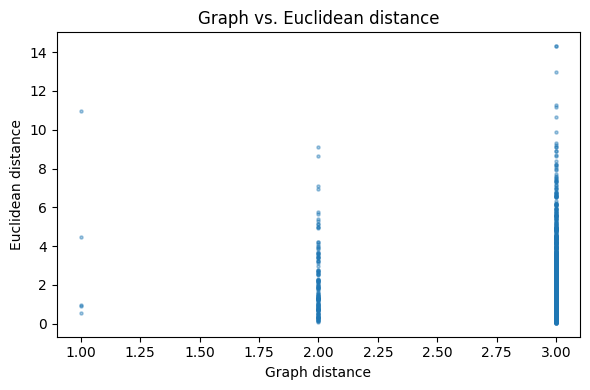

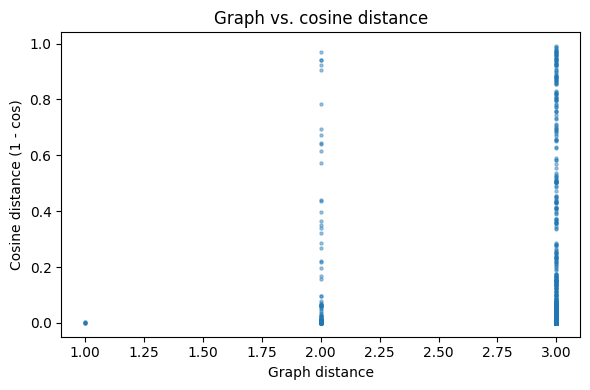

{'corr_euclidean': 0.008600553901177975, 'corr_cosine': 0.016670143575273442}

In [9]:
def analyze_distance_correlations(
    G: nx.Graph,
    df_all: pd.DataFrame,
    max_pairs: int = 3000,
    max_graph_dist: int = 3,
    seed: int = 42,
):
    rng = np.random.default_rng(seed)

    emb_cols = [c for c in df_all.columns if c.startswith("dim_")]
    if not emb_cols:
        raise ValueError("Nenhuma coluna dim_* encontrada em df_all.")

    node_to_idx = {n: i for i, n in enumerate(df_all["node"].tolist())}
    emb_matrix = df_all[emb_cols].to_numpy()

    nodes = list(G.nodes())
    pairs_data = []
    attempts = 0
    max_attempts = max_pairs * 10

    while len(pairs_data) < max_pairs and attempts < max_attempts:
        u = rng.choice(nodes)
        v = rng.choice(nodes)
        if u == v:
            attempts += 1
            continue
        try:
            d_g = nx.shortest_path_length(G, source=u, target=v)
        except nx.NetworkXNoPath:
            attempts += 1
            continue
        if d_g > max_graph_dist:
            attempts += 1
            continue
        if u not in node_to_idx or v not in node_to_idx:
            attempts += 1
            continue

        iu = node_to_idx[u]
        iv = node_to_idx[v]
        emb_u = emb_matrix[iu]
        emb_v = emb_matrix[iv]

        d_e = float(np.linalg.norm(emb_u - emb_v))
        dot = float(np.dot(emb_u, emb_v))
        nu = float(np.linalg.norm(emb_u)) + 1e-9
        nv = float(np.linalg.norm(emb_v)) + 1e-9
        cos_sim = dot / (nu * nv)
        cos_dist = 1.0 - cos_sim

        pairs_data.append((u, v, d_g, d_e, cos_dist))
        attempts += 1

    df_pairs = pd.DataFrame(
        pairs_data,
        columns=["u", "v", "graph_dist", "euclidean_dist", "cosine_dist"],
    )

    out_path = RESULTS_DIR / "07_distance_correlations.csv"
    df_pairs.to_csv(out_path, index=False)
    print("Resultados salvos em:", out_path)

    corr_e = df_pairs["graph_dist"].corr(df_pairs["euclidean_dist"])
    corr_c = df_pairs["graph_dist"].corr(df_pairs["cosine_dist"])
    print(f"Corr(graph_dist, euclidean_dist) = {corr_e:.4f}")
    print(f"Corr(graph_dist, cosine_dist)   = {corr_c:.4f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(df_pairs["graph_dist"], df_pairs["euclidean_dist"], s=5, alpha=0.4)
    plt.xlabel("Graph distance")
    plt.ylabel("Euclidean distance")
    plt.title("Graph vs. Euclidean distance")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.scatter(df_pairs["graph_dist"], df_pairs["cosine_dist"], s=5, alpha=0.4)
    plt.xlabel("Graph distance")
    plt.ylabel("Cosine distance (1 - cos)")
    plt.title("Graph vs. cosine distance")
    plt.tight_layout()
    plt.show()

    return df_pairs, {"corr_euclidean": corr_e, "corr_cosine": corr_c}


df_pairs, dist_corrs = analyze_distance_correlations(G, df_all)
dist_corrs

## 3. Preservação de vizinhança (versão leve)

- Amostras **300 nós** (por padrão)
- Vizinhança no grafo: BFS até raio 2, no máximo `k=10` vizinhos
- Vizinhança no embedding: 10 mais próximos (distância euclidiana)
- Métrica: Jaccard entre os conjuntos de vizinhos


Resultados de preservação de vizinhança salvos em: /workspace/results/07_neighborhood_preservation.csv
Resumo do overlap Jaccard:


count    300.000000
mean       0.012445
std        0.031194
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.272727
Name: overlap_jaccard, dtype: float64

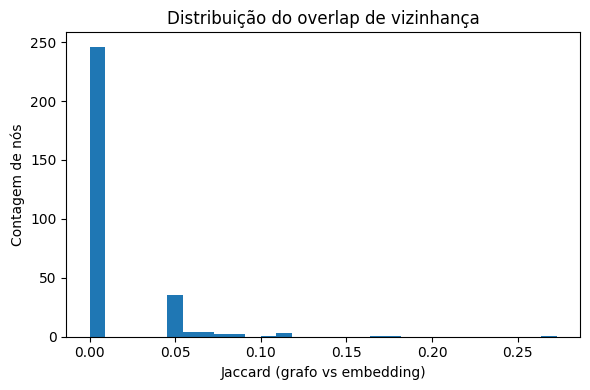

,node,overlap_jaccard,graph_neighbors,embedding_neighbors
0,11727,0.052632,10,10
1,17913,0.000000,10,10
2,2941,0.000000,10,10
3,10198,0.000000,9,10
4,2071,0.000000,10,10


In [10]:
def compute_neighborhood_preservation(
    G: nx.Graph,
    df_all: pd.DataFrame,
    k: int = 10,
    num_nodes_sample: int = 300,
    max_graph_radius: int = 2,
    seed: int = 42,
):
    rng = np.random.default_rng(seed)

    emb_cols = [c for c in df_all.columns if c.startswith("dim_")]
    emb_matrix = df_all[emb_cols].to_numpy()
    nodes = df_all["node"].to_numpy()
    node_to_idx = {n: i for i, n in enumerate(nodes)}

    if num_nodes_sample > len(nodes):
        num_nodes_sample = len(nodes)
    sampled_nodes = rng.choice(nodes, size=num_nodes_sample, replace=False)

    def get_graph_neighbors(u):
        neigh = []
        for v, d in nx.single_source_shortest_path_length(G, source=u, cutoff=max_graph_radius).items():
            if v == u:
                continue
            neigh.append((v, d))
        neigh.sort(key=lambda x: x[1])
        return [v for v, _ in neigh[:k]]

    def get_embedding_neighbors(u):
        iu = node_to_idx[u]
        emb_u = emb_matrix[iu]
        dists = np.linalg.norm(emb_matrix - emb_u, axis=1)
        order = np.argsort(dists)
        neigh_idx = [i for i in order if nodes[i] != u][:k]
        return nodes[neigh_idx]

    results = []
    for u in sampled_nodes:
        try:
            neigh_g = set(get_graph_neighbors(u))
        except Exception:
            continue
        if not neigh_g:
            continue
        neigh_e = set(get_embedding_neighbors(u))
        if not neigh_e:
            continue

        inter = len(neigh_g & neigh_e)
        union = len(neigh_g | neigh_e)
        jaccard = inter / union if union > 0 else 0.0

        results.append({
            "node": u,
            "overlap_jaccard": jaccard,
            "graph_neighbors": len(neigh_g),
            "embedding_neighbors": len(neigh_e),
        })

    df_neigh = pd.DataFrame(results)
    out_path = RESULTS_DIR / "07_neighborhood_preservation.csv"
    df_neigh.to_csv(out_path, index=False)
    print("Resultados de preservação de vizinhança salvos em:", out_path)

    print("Resumo do overlap Jaccard:")
    display(df_neigh["overlap_jaccard"].describe())

    plt.figure(figsize=(6, 4))
    plt.hist(df_neigh["overlap_jaccard"], bins=30)
    plt.xlabel("Jaccard (grafo vs embedding)")
    plt.ylabel("Contagem de nós")
    plt.title("Distribuição do overlap de vizinhança")
    plt.tight_layout()
    plt.show()

    return df_neigh


df_neigh = compute_neighborhood_preservation(G, df_all)
df_neigh.head()

## 4. Comunidades no embedding (Label Propagation + LCC)

- Usamos **apenas a LCC** para acelerar
- Comunidades via **Label Propagation** (rápido)
- PCA 2D (se `scikit-learn` estiver disponível)
- Salvamos CSV com coluna `community` e fazemos scatter colorido


Comunidades detectadas (LPA): 2508
CSV com comunidades (LCC) salvo em: /workspace/results/07_embeddings_lcc_communities.csv


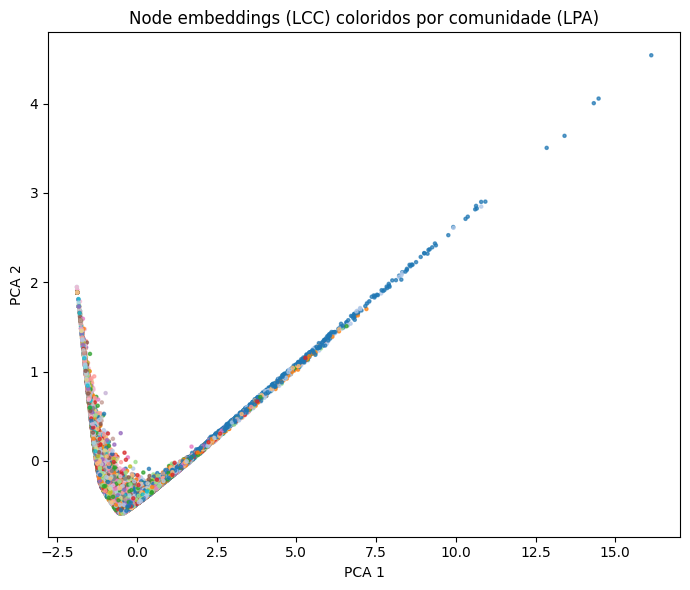

,node,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_63,norm,degree,clustering,deg_cent,clo_cent,bet_cent,community,pca_x,pca_y
0,0,0.000000,0.011541,0.039987,0.0,0.0,0.004841,0.000000,0.016014,0.052793,...,0.115156,0.743526,3,1.0,0.000140,0.169169,0.0,0,-1.147503,-0.164443
1,1,0.667237,0.446466,0.000000,0.0,0.0,0.557961,0.618814,0.482417,0.625293,...,0.000000,2.844969,8,1.0,0.000374,0.205704,0.0,1,1.646379,0.028343
2,2,0.231627,0.167816,0.000000,0.0,0.0,0.188937,0.225705,0.147563,0.229925,...,0.000000,1.056392,2,1.0,0.000094,0.203649,0.0,3,-0.087403,-0.483977
3,3,0.061759,0.055503,0.009762,0.0,0.0,0.055709,0.062112,0.042891,0.100044,...,0.045916,0.566871,4,1.0,0.000187,0.190477,0.0,5,-0.824655,-0.400582
4,4,0.170389,0.125884,0.000000,0.0,0.0,0.142038,0.169558,0.110137,0.188199,...,0.000000,0.840152,5,1.0,0.000234,0.196571,0.0,7,-0.320309,-0.524773


In [11]:
from networkx.algorithms.community import label_propagation_communities

def detect_communities_lpa(G: nx.Graph):
    comms = list(label_propagation_communities(G))
    node_to_comm = {}
    for cid, comm in enumerate(comms):
        for n in comm:
            node_to_comm[n] = cid
    print(f"Comunidades detectadas (LPA): {len(comms)}")
    return node_to_comm


def add_pca_to_df(df_all: pd.DataFrame, n_components: int = 2, random_state: int = 42):
    try:
        from sklearn.decomposition import PCA
    except ImportError:
        print("scikit-learn não está disponível; pulando PCA.")
        return df_all

    emb_cols = [c for c in df_all.columns if c.startswith("dim_")]
    emb_np = df_all[emb_cols].to_numpy()
    pca = PCA(n_components=n_components, random_state=random_state)
    emb_pca = pca.fit_transform(emb_np)
    df_all = df_all.copy()
    df_all["pca_x"] = emb_pca[:, 0]
    df_all["pca_y"] = emb_pca[:, 1]
    return df_all


def plot_communities_in_embedding_lcc(G: nx.Graph, df_all: pd.DataFrame):
    # usa só a LCC
    lcc_nodes = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(lcc_nodes).copy()
    df_lcc = df_all[df_all["node"].isin(lcc_nodes)].reset_index(drop=True)

    node_to_comm = detect_communities_lpa(G_lcc)
    df_lcc["community"] = df_lcc["node"].map(node_to_comm)

    if "pca_x" not in df_lcc.columns or "pca_y" not in df_lcc.columns:
        df_lcc = add_pca_to_df(df_lcc)

    out_path = RESULTS_DIR / "07_embeddings_lcc_communities.csv"
    df_lcc.to_csv(out_path, index=False)
    print("CSV com comunidades (LCC) salvo em:", out_path)

    if "pca_x" in df_lcc.columns and "pca_y" in df_lcc.columns:
        plt.figure(figsize=(7, 6))
        scatter = plt.scatter(
            df_lcc["pca_x"], df_lcc["pca_y"], c=df_lcc["community"], s=5, alpha=0.7, cmap="tab20"
        )
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title("Node embeddings (LCC) coloridos por comunidade (LPA)")
        plt.tight_layout()
        plt.show()
    else:
        print("PCA não disponível; gráfico não gerado.")

    return df_lcc


df_comm = plot_communities_in_embedding_lcc(G, df_all)
df_comm.head()

## 5. Resumo final das análises (para relatório/TCC)

Consolidamos números-chave para texto do TCC/artigo e salvamos em CSV:
- número de nós/arestas, densidade
- média e desvio das normas dos embeddings
- correlação entre distância no grafo e distâncias no embedding
- overlap médio de vizinhança (Jaccard)
- número de comunidades detectadas na LCC


In [12]:
summary = {}

# Informações gerais do grafo
summary["num_nodes"] = G.number_of_nodes()
summary["num_edges"] = G.number_of_edges()
summary["density"] = nx.density(G)

# Estatísticas das normas dos embeddings
summary["emb_norm_mean"] = float(df_all["norm"].mean())
summary["emb_norm_std"]  = float(df_all["norm"].std())

# Correlações de distância
summary["corr_graph_euclidean"] = float(dist_corrs["corr_euclidean"])
summary["corr_graph_cosine"]    = float(dist_corrs["corr_cosine"])

# Overlap médio de vizinhança
summary["avg_neighborhood_jaccard"] = float(df_neigh["overlap_jaccard"].mean())

# Número de comunidades na LCC
summary["num_communities_lcc"] = int(df_comm["community"].nunique())

df_summary = pd.DataFrame([summary])
out_path = RESULTS_DIR / "07_advanced_embedding_analysis_summary.csv"
df_summary.to_csv(out_path, index=False)
print("Resumo das análises salvo em:", out_path)
display(df_summary)

Resumo das análises salvo em: /workspace/results/07_advanced_embedding_analysis_summary.csv


,num_nodes,num_edges,density,emb_norm_mean,emb_norm_std,corr_graph_euclidean,corr_graph_cosine,avg_neighborhood_jaccard,num_communities_lcc
0,23133,93439,0.000349,1.766656,1.186306,0.008601,0.01667,0.012445,2508


In [13]:
print('Notebook 07 finished successfully. 🚀')

Notebook 07 finished successfully. 🚀
